Like anything there is an optimum value for relaxing. Here relaxing menas working productively without high stress.The experts say some stress is important to motivate us to do impotant tasks in life. An ideal value unique to each individual based on the person's DNA and the way of living.

Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work for. 

In [65]:
### Get the modules
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [66]:
#read the user engagement data
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [67]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(
    engagement['user_id'].nunique(), len(engagement)
))

There were 8823 users and 207917 total logins


In [68]:
# convert time_stamp into datetime format
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [69]:
# define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [70]:
# run the function on all users
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [71]:
print('There were {} adopted users out of {} users'.format(
    sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


### 1.2 User data

In [72]:
# read the user data
# some columns such as name, email address are not useful here
# let's not read them
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv('takehome_users.csv', usecols=cols)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


There were likely too many organizations and user invites to model. Let's do a quick survey of the organizations with most users and users who sent out most invites. Then drop those two features.

In [73]:
# 5 Organizations with most users
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [74]:
# 5 Users with most invites
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
Name: invited_by_user_id, dtype: int64

In [75]:
# remove those two features
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

From the creation time and last session time, we can engineer two features that can be useful.<br>
It is possible that the history of using the software might be a factor of becoming "adopted users". In other words, users who have used the software for a long time might be more likely to be "adopted users" than those who had just signed up.<br>
It is likely that user adoption rate vary through time, so it is useful to take a look at account age (based on creation time) as well.

In [76]:
# create a feature of user history
# convert both time features into datetime
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days
# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days
# drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [77]:
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [78]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


There were 8823 users who had "user history" out of 12000. It was not clear from the challenge description whether data for other users were missing, or don't exist at all. However, given there are users who has history of 0 days, I think the engagement data for the other users were simply missing. Therefore, I will remove these users from the analysis.

In [79]:
# merge user data and "adopted user" variable
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

Exploratory Data Analysis

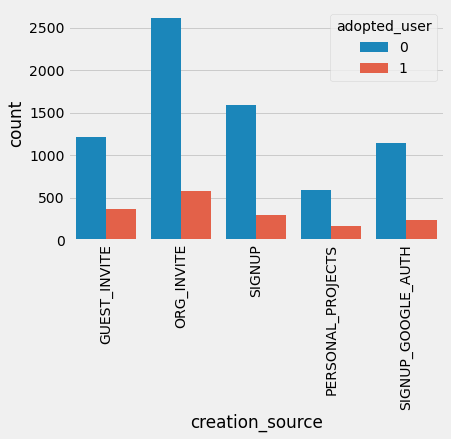

In [80]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [81]:
# doesn't look like there was much difference among creation sources
# let's do a chi2 test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [82]:
# hmm, chi2 test significant, but how much was the difference
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

OK, slightly higher "adopted user" rate in guest_invite and personal_projects, that makes sense because users who got invite probably was collaborting with others, and users who have personal projects are likely to have more personal interest that make them more engaged.

In [83]:
# check mailing list and marketing drip
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [84]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148219, p = 0.4820695142048773


In [85]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [86]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940364, p = 0.6870022995069647


There was really no difference between users who signed up or not for mailing list and marketing drip.

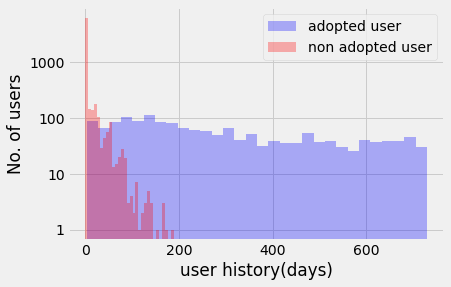

In [87]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(data, 'history', 'user history(days)')

Pretty clear that users with long history are more likely to be adopted users.

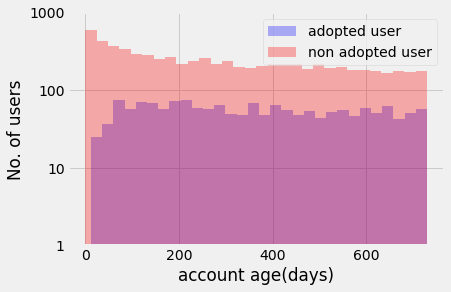

In [88]:
plot_hist_days(data, 'account_age', 'account age(days)')

Not surprisingly, the adoption rate is lower in very new accounts. Other than that, the adoption rate didn't change much over the past two years.

Modeling

In [89]:
# make dummy variable for creation source
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)
# though account_age and history have different scales than other features,
# I plan to use random forest model, which is not affectd by the different scales
# no need to scale the data
# create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [90]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.9626721517744391


In [91]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9519492293744334
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.93      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [92]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.892330
account_age                   0.091811
opted_in_to_mailing_list      0.003213
enabled_for_marketing_drip    0.002973
SIGNUP                        0.002952
ORG_INVITE                    0.002545
SIGNUP_GOOGLE_AUTH            0.002109
PERSONAL_PROJECTS             0.002066
dtype: float64


We can see that history is at the top of the list. Based on this,recomendation is  that an effective way of growing users might be encouraging existing users to log in and use the software after they had accounts for sometime.